# Graph Neural Network Types and Examples

### 🧠 Graph Convolutional Network (GCN)

The **Graph Convolutional Network** (Kipf & Welling, 2016) is one of the foundational models in graph deep learning. It updates each node's representation by **averaging (or aggregating) its neighbors' features**, followed by a learnable linear transformation.

---

#### 🔁 GCN Update Rule

$$
h_i^{(l+1)} = \sigma\left( \sum_{j \in \mathcal{N}_i \cup \{i\}} \frac{1}{\sqrt{d_i d_j}} W^{(l)} h_j^{(l)} \right)
$$

---

#### 📘 Notation

- $h_i^{(l)}$: embedding of node $i$ at layer $l$
- $\mathcal{N}_i$: neighbors of node $i$
- $W^{(l)}$: learnable weight matrix at layer $l$
- $d_i$: degree of node $i$
- $\sigma$: activation function (e.g., ReLU)
- The term $\frac{1}{\sqrt{d_i d_j}}$ ensures normalization (symmetric normalization of adjacency matrix)

---

#### 🧠 Intuition

1. Each node collects features from its neighbors (including itself).
2. The features are **normalized** to avoid scale issues in graphs with varying degrees.
3. The normalized sum is passed through a **linear transformation** and a **nonlinearity**.

---

#### 🧠 Graph Convolutional Network (GCN) — With Debug Prints

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def normalize_adj(adj):
    """Symmetric normalization of adjacency matrix."""
    deg = adj.sum(dim=1)
    deg_inv_sqrt = torch.pow(deg, -0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0.0
    D_inv_sqrt = torch.diag(deg_inv_sqrt)
    adj_norm = D_inv_sqrt @ adj @ D_inv_sqrt
    print("\n===Normalized adjacency matrix (D^{-1/2} A D^{-1/2})===")
    print(adj_norm)
    return adj_norm

class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats, layer_name=""):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.layer_name = layer_name

    def forward(self, h, adj):
        print(f"\n===Input features to {self.layer_name}===")
        print(h)

        adj_norm = normalize_adj(adj)
        h_agg = adj_norm @ h
        print(f"\n===Aggregated features (A_norm @ h) in {self.layer_name}===")
        print(h_agg)

        h_proj = self.linear(h_agg)
        print(f"\n===Projected features (Linear transform) in {self.layer_name}===")
        print(h_proj)

        h_out = F.relu(h_proj)
        print(f"\n===Activated features (ReLU) in {self.layer_name}===")
        print(h_out)

        return h_out

#### 🔁 GCN Model Definition

In [8]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_feats, layer_name="GCN Layer 1")
        self.gcn2 = GCNLayer(hidden_feats, out_feats, layer_name="GCN Layer 2")

    def forward(self, h, adj):
        h = self.gcn1(h, adj)
        h = self.gcn2(h, adj)
        return h

#### 🔢 Example Usage

In [9]:
# Example input
print("===Example graph with 4 nodes, each with 3 features===")
x = torch.randn(4, 3)
print(x)

print("\n===Binary adjacency matrix with self-loops===")
adj = torch.tensor([
    [1, 1, 0, 1],
    [1, 1, 1, 0],
    [0, 1, 1, 1],
    [1, 0, 1, 1]
], dtype=torch.float32)
print(adj)

===Example graph with 4 nodes, each with 3 features===
tensor([[-0.9737, -0.6988,  1.8476],
        [ 0.8427,  0.1647,  0.6772],
        [-0.6611,  0.0632, -0.6865],
        [ 0.8908, -0.5866,  1.5085]])

===Binary adjacency matrix with self-loops===
tensor([[1., 1., 0., 1.],
        [1., 1., 1., 0.],
        [0., 1., 1., 1.],
        [1., 0., 1., 1.]])


c:\ProgramData\anaconda3\envs\sina\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


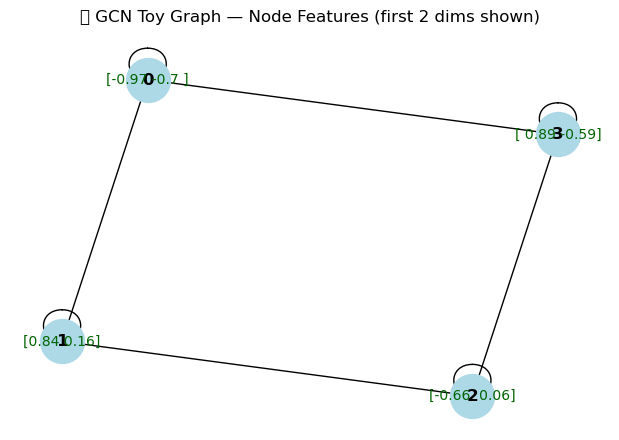

In [11]:
# Create a graph from the adjacency matrix
G = nx.from_numpy_array(adj.numpy())

# Prepare 2D feature labels for display (project 3D → 2D)
features_np = x.detach().numpy()
labels = {i: f"{features_np[i][:2].round(2)}" for i in range(x.size(0))}

# Layout
pos = nx.spring_layout(G, seed=48)

plt.figure(figsize=(6, 4))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, font_weight='bold')
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_color='darkgreen')

plt.title("🧩 GCN Toy Graph — Node Features (first 2 dims shown)")
plt.axis('off')
plt.show()

c:\ProgramData\anaconda3\envs\sina\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128208 (\N{TRIANGULAR RULER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


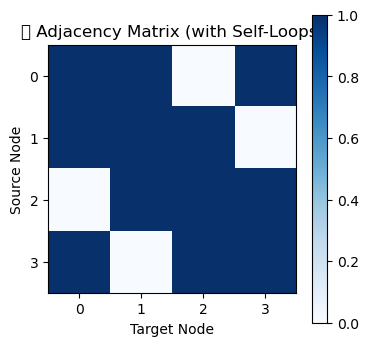

In [12]:
plt.figure(figsize=(4, 4))
plt.imshow(adj.numpy(), cmap="Blues")
plt.title("📐 Adjacency Matrix (with Self-Loops)")
plt.colorbar()
plt.xticks(range(adj.size(0))), plt.yticks(range(adj.size(0)))
plt.xlabel("Target Node"), plt.ylabel("Source Node")
plt.show()

In [13]:
print("\n===Output embeddings from a 2-layer GCN model===")
model = GCN(in_feats=3, hidden_feats=8, out_feats=2)
output = model(x, adj)

print("\n===Final output embeddings===")
print(output)


===Output embeddings from a 2-layer GCN model===

===Input features to GCN Layer 1===
tensor([[-0.9737, -0.6988,  1.8476],
        [ 0.8427,  0.1647,  0.6772],
        [-0.6611,  0.0632, -0.6865],
        [ 0.8908, -0.5866,  1.5085]])

===Normalized adjacency matrix (D^{-1/2} A D^{-1/2})===
tensor([[0.3333, 0.3333, 0.0000, 0.3333],
        [0.3333, 0.3333, 0.3333, 0.0000],
        [0.0000, 0.3333, 0.3333, 0.3333],
        [0.3333, 0.0000, 0.3333, 0.3333]])

===Aggregated features (A_norm @ h) in GCN Layer 1===
tensor([[ 0.2532, -0.3736,  1.3444],
        [-0.2641, -0.1570,  0.6128],
        [ 0.3574, -0.1196,  0.4997],
        [-0.2480, -0.4074,  0.8899]])

===Projected features (Linear transform) in GCN Layer 1===
tensor([[ 1.2892, -0.3185, -0.2457, -0.7507,  0.2994,  0.0230,  0.2162, -0.8639],
        [ 0.7251, -0.3712, -0.0182, -0.5544, -0.2791,  0.0564, -0.1459, -0.4930],
        [ 0.9051, -0.1192, -0.1755, -0.2776, -0.1951,  0.0023, -0.0522, -0.8081],
        [ 0.8698, -0.4020,  

### 🔧 PyTorch Geometric: GCN Example

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Step 1: Create a toy graph with 4 nodes
print("===Step 1: Create a toy graph with 4 nodes, 3 features per node===")
x = torch.randn((4, 3))  # 4 nodes, 3 features per node
print(x)


print("\nCreate edge index of undirected edges (COO format)")
edge_index = torch.tensor([
    [0, 1, 1, 2, 2, 3, 3, 0],
    [1, 0, 2, 1, 3, 2, 0, 3]
], dtype=torch.long)  # undirected edges (COO format)

data = Data(x=x, edge_index=edge_index)

# Step 2: Define a 2-layer GCN model
import torch.nn as nn

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Step 3: Instantiate and run the model
model = GCN(in_channels=3, hidden_channels=8, out_channels=2)
output = model(data.x, data.edge_index)

print("Output node embeddings:\n", output)

### 📌 Summary

- GCN is efficient and effective for **semi-supervised node classification**.
- It assumes homophily: **connected nodes tend to have similar features/labels**.
- Use `GCNConv` from PyG to easily build models on any graph.

## 2) 📘 GraphSAGE: Graph Sample and Aggregation

GraphSAGE (Hamilton et al., 2017) is a popular GNN framework that learns node embeddings by **sampling and aggregating features from the node's local neighborhood**. This allows it to generalize to **unseen nodes** (inductive learning) and **scale** to large graphs by sampling fixed-size neighborhoods.

Unlike transductive GNNs, GraphSAGE supports **inductive learning**, allowing it to generalize to unseen nodes or graphs.

---

#### 🔁 Update Rule

$$
\begin{aligned}
h_{\mathcal{N}_i}^l &= \text{AGGREGATE}_l\left(\{ h_j^l \mid j \in \mathcal{N}_i \} \right) \\
h_i^{l+1} &= \delta\left( W^l \cdot \left[ h_i^l \, \| \, h_{\mathcal{N}_i}^l \right] \right)
\end{aligned}
$$


---

#### 🔍 Notation
   - $h_i^l$: the **embedding (feature vector)** of node $i$ at layer $l$.
   - $\mathcal{N}_i$: the **set of neighbors** of node $i$.
   - $h_{\mathcal{N}_i}^l$: the **aggregated embedding** of the neighbors of node $i$ at layer $l$.
   - $\text{AGGREGATE}_l$: a function (like mean, max, or LSTM-based) used to **combine neighbor features** at layer $l$.
   - $[ h_i^l \, \| \, h_{\mathcal{N}_i}^l ]$: **concatenation** of node $i$'s own embedding with its aggregated neighborhood embedding.
   - $W^l$: a **learnable weight matrix** for layer $l$.
   - $\delta$: a **nonlinear activation function** (e.g., ReLU).

---

### Line-by-Line Breakdown:

1. **Neighbor Aggregation**:
   $$
   h_{\mathcal{N}_i}^l = \text{AGGREGATE}_l\left(\{ h_j^l, \forall j \in \mathcal{N}_i \} \right)
   $$
   - For each node $i$, you gather the embeddings of its neighbors $j \in \mathcal{N}_i$.
   - These are passed through an aggregation function to get a **single vector** representing the neighborhood.

2. **Node Update**:
   $$
   h_i^{l+1} = \delta\left(W^l \left[ h_i^l \, \| \, h_{\mathcal{N}_i}^l \right]\right)
   $$
   - You **concatenate** the current embedding of node $i$ with the aggregated neighborhood vector.
   - Apply a linear transformation using $W^l$, followed by a nonlinearity $\delta$, to get the new embedding for node $i$ at layer $l+1$.

---

#### 🧠 Intuition

1. **Neighborhood Aggregation**: Each node gathers features from its neighbors using an aggregation function.
2. **Update Step**: The node combines its own features with the aggregated neighborhood features and passes the result through a linear transformation followed by a non-linearity.
3. **Inductive Learning**: GraphSAGE can generalize to nodes not seen during training by learning how to aggregate features rather than memorizing node embeddings.

---

#### 🔗 Common Aggregation Functions

| Aggregator | Description                          |
|------------|--------------------------------------|
| Mean       | Averages neighbor features           |
| MaxPool    | Applies non-linear transform + max   |
| LSTM       | Learns order-sensitive aggregation   |
| Sum        | Sums neighbor features               |

#### 🧠 GraphSAGE Layer in PyTorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphSAGELayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GraphSAGELayer, self).__init__()
        self.linear = nn.Linear(2 * in_feats, out_feats)  # Because of concatenation

    def forward(self, h, adj):
        """
        h:     Tensor of shape (N, in_feats) - node features
        adj:   Adjacency matrix (N x N) - binary or normalized
        """
        # Aggregate neighbor features (mean aggregation)
        h_neigh = torch.matmul(adj, h) / adj.sum(1, keepdim=True).clamp(min=1)

        # Concatenate self and neighbor embeddings
        h_cat = torch.cat([h, h_neigh], dim=1)  # (N, 2 * in_feats)

        # Linear transformation + activation
        return F.relu(self.linear(h_cat))

#### 🔁 Using the Layer in a GNN Model

In [2]:
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(GraphSAGE, self).__init__()
        self.sage1 = GraphSAGELayer(in_feats, hidden_feats)
        self.sage2 = GraphSAGELayer(hidden_feats, out_feats)

    def forward(self, h, adj):
        h = self.sage1(h, adj)
        h = self.sage2(h, adj)
        return h

#### 🔢 Example Usage

In [4]:
print("===Example graph with 4 nodes, each with 3 features===")
node_features = torch.randn(4, 3)
print(node_features)

print("\n===Simple binary adjacency matrix (no self-loops here)===")
adj_matrix = torch.tensor([
    [0, 1, 0, 1],
    [1, 0, 1, 0],
    [0, 1, 0, 1],
    [1, 0, 1, 0]
], dtype=torch.float32)
print(adj_matrix)


print("\n===Output embeddings from a 2 layer GraphSAGE model with 8 hidden features, and 2 output features===")
model = GraphSAGE(in_feats=3, hidden_feats=8, out_feats=2)
output_embeddings = model(node_features, adj_matrix)

print(output_embeddings)

===Example graph with 4 nodes, each with 3 features===
tensor([[-0.3871, -0.1645,  0.6380],
        [-0.1153, -1.4920, -0.6999],
        [ 1.1096,  1.1050,  2.3926],
        [ 2.1535, -1.3734, -0.0735]])

===Simple binary adjacency matrix (no self-loops here)===
tensor([[0., 1., 0., 1.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [1., 0., 1., 0.]])

===Output embeddings from a 2 layer GraphSAGE model with 8 hidden features, and 2 output features===
tensor([[0.1590, 0.0000],
        [0.1053, 0.0000],
        [0.0914, 0.0000],
        [0.0687, 0.0000]], grad_fn=<ReluBackward0>)


#### 📝 Notes:
This uses mean aggregation, which is common in GraphSAGE.

The adjacency matrix should be preprocessed (e.g., normalized) for better results.

For real-world applications, you might use mini-batch neighborhood sampling (especially on large graphs), which libraries like PyTorch Geometric handle efficiently.

#### 📦 PyTorch Geometric: GraphSAGE Example

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data

# Step 1: Define a toy graph
# 4 nodes with 3-dimensional features
print("===Step 1: Define a toy graph===")
print("4 nodes with 3-dimensional features")
x = torch.randn((4, 3))
print(x)


# Edge index in COO format (2 x num_edges)
# Here: a simple undirected graph
print("\n Edge index in COO format (2 x num_edges)")
print("Here: a simple undirected graph")
edge_index = torch.tensor([
    [0, 1, 1, 2, 2, 3, 3, 0],  # Source nodes
    [1, 0, 2, 1, 3, 2, 0, 3]   # Target nodes
], dtype=torch.long)
print(edge_index)

print("\nPyTorch Geometric (PyG) Data object")
data = Data(x=x, edge_index=edge_index)
print(data)

# Step 2: Define a simple 2-layer GraphSAGE model
print("\n===Step 2: Define a simple 2-layer GraphSAGE model===")
import torch.nn as nn

class GraphSAGE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Step 3: Initialize and run the model
print("\n===Step 3: Initialize and run the model===")
model = GraphSAGE(in_channels=3, hidden_channels=8, out_channels=2)
output = model(data.x, data.edge_index)

print("Output node embeddings:\n", output)


===Step 1: Define a toy graph===
4 nodes with 3-dimensional features
tensor([[-0.2721,  0.8642, -1.4706],
        [-0.8519, -1.2012,  0.3967],
        [ 0.1071, -0.2973, -0.3928],
        [-1.1830,  0.8662, -3.5741]])

 Edge index in COO format (2 x num_edges)
Here: a simple undirected graph
tensor([[0, 1, 1, 2, 2, 3, 3, 0],
        [1, 0, 2, 1, 3, 2, 0, 3]])

PyTorch Geometric (PyG) Data object
Data(x=[4, 3], edge_index=[2, 8])

===Step 2: Define a simple 2-layer GraphSAGE model===

===Step 3: Initialize and run the model===
Output node embeddings:
 tensor([[-0.3304,  0.1242],
        [ 0.0688,  0.3232],
        [-0.2614,  0.0162],
        [-0.3336,  0.6951]], grad_fn=<AddBackward0>)


## 3) 🔍 Graph Attention Network (GAT) — High-Level Summary

**Graph Attention Networks (GATs)** introduce attention mechanisms to graph neural networks, allowing each node to learn **which of its neighbors are most important** when aggregating information.

---

### 🧠 Intuition

- Traditional GCNs treat **all neighbors equally** when aggregating their features.
- GATs **learn a weight (attention score)** for each neighbor, so more relevant neighbors contribute more to the node's representation.

---

### ⚙️ Key Mechanism

1. **Linear Transformation**:  
   Each node’s features are first linearly transformed using a shared weight matrix.

2. **Self-Attention on Edges**:  
   For each edge $(i, j)$, compute an attention coefficient:
   $$
   e_{ij} = \text{LeakyReLU}\left( \mathbf{a}^\top [W\mathbf{h}_i \, \| \, W\mathbf{h}_j] \right)
   $$
   where:
   - $\mathbf{h}_i$ is the input feature of node $i$
   - $W$ is a learnable linear transformation
   - $\mathbf{a}$ is a learnable attention vector
   - $\|$ denotes concatenation

3. **Normalization (Softmax)**:
   $$
   \alpha_{ij} = \text{softmax}_j(e_{ij}) = \frac{\exp(e_{ij})}{\sum_{k \in \mathcal{N}(i)} \exp(e_{ik})}
   $$
   So attention scores are normalized over the neighbors.

4. **Aggregation**:
   $$
   \mathbf{h}_i' = \sigma\left( \sum_{j \in \mathcal{N}(i)} \alpha_{ij} W \mathbf{h}_j \right)
   $$
   where $\sigma$ is typically an activation function like ReLU.

5. **Multi-Head Attention**:  
   GAT typically uses multiple attention heads in parallel, then concatenates (or averages) their outputs.

---

### ✨ Benefits

- Learns **importance weights** for each neighbor — very flexible.
- Can handle **graphs with noisy or irrelevant connections** more robustly.
- Doesn't require costly matrix inversions like in GCNs.

---

### 📘 Summary Diagram (Text Form)

```
     Node i
      |
  [Feature Vector]
      |
Linear Transformation
      |
  Attention Coeffs      <--- Pairwise with each neighbor
      |
   Softmax + Weighting
      |
   Weighted Sum of Neighbor Features
      |
   New Feature Vector
```

---

### 🧪 PyTorch GAT Example (From Scratch, with Debug Prints)

✅ Define GAT Layer (Single-head)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GATLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super().__init__()
        self.W = nn.Linear(in_feats, out_feats, bias=False)
        self.attn_fc = nn.Linear(2 * out_feats, 1, bias=False)
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, h, adj):
        print("=== Original Node Features ===")
        print(h)

        Wh = self.W(h)  # Linear transformation
        print("\n=== After Linear Transformation (W @ h) ===")
        print(Wh)

        N = h.shape[0]
        a_input = torch.cat([
            Wh.repeat(1, N).view(N * N, -1),
            Wh.repeat(N, 1)
        ], dim=1).view(N, N, 2 * Wh.shape[1])  # Pairwise concat

        print("\n=== Concatenated Node Pairs (for attention) ===")
        print(a_input)

        e = self.leaky_relu(self.attn_fc(a_input).squeeze(-1))
        print("\n=== Attention Coefficients e_{ij} ===")
        print(e)

        e = e.masked_fill(adj == 0, float('-inf'))  # Mask non-edges
        alpha = F.softmax(e, dim=1)
        print("\n=== Normalized Attention α_{ij} (after softmax) ===")
        print(alpha)

        h_prime = torch.matmul(alpha, Wh)
        print("\n=== Output Features h' (weighted sum of neighbors) ===")
        print(h_prime)

        return h_prime

🧪 Toy Graph and Model

In [2]:
# Example graph with 4 nodes and 3 features
x = torch.randn(4, 3)
adj = torch.tensor([
    [1, 1, 0, 1],
    [1, 1, 1, 0],
    [0, 1, 1, 1],
    [1, 0, 1, 1]
], dtype=torch.float32)

model = GATLayer(in_feats=3, out_feats=2)
out = model(x, adj)

=== Original Node Features ===
tensor([[ 0.7153, -1.0243,  0.8414],
        [-0.7271, -0.9109, -1.3274],
        [-0.1189,  0.3870,  0.6106],
        [-0.7753, -0.3126, -0.8415]])

=== After Linear Transformation (W @ h) ===
tensor([[-0.5225,  1.2591],
        [ 0.4376, -0.6682],
        [-0.1014,  0.0692],
        [ 0.3801, -0.7131]], grad_fn=<MmBackward0>)

=== Concatenated Node Pairs (for attention) ===
tensor([[[-0.5225,  1.2591, -0.5225,  1.2591],
         [-0.5225,  1.2591,  0.4376, -0.6682],
         [-0.5225,  1.2591, -0.1014,  0.0692],
         [-0.5225,  1.2591,  0.3801, -0.7131]],

        [[ 0.4376, -0.6682, -0.5225,  1.2591],
         [ 0.4376, -0.6682,  0.4376, -0.6682],
         [ 0.4376, -0.6682, -0.1014,  0.0692],
         [ 0.4376, -0.6682,  0.3801, -0.7131]],

        [[-0.1014,  0.0692, -0.5225,  1.2591],
         [-0.1014,  0.0692,  0.4376, -0.6682],
         [-0.1014,  0.0692, -0.1014,  0.0692],
         [-0.1014,  0.0692,  0.3801, -0.7131]],

        [[ 0.3801, -

### 🧪 PyTorch Geometric GAT Example (with Debug Prints)
PyTorch Geometric (PyG) provides a clean GAT layer — let's build a simple model and inspect its outputs.

In [3]:
import torch
from torch_geometric.nn import GATConv
from torch_geometric.data import Data

# Define toy graph in edge index form (COO format)
edge_index = torch.tensor([
    [0, 0, 1, 1, 2, 2, 3, 3],
    [1, 3, 0, 2, 1, 3, 0, 2]
], dtype=torch.long)  # 8 edges, undirected

x = torch.randn(4, 3)  # 4 nodes, 3 features

data = Data(x=x, edge_index=edge_index)

# GAT with 1 attention head
gat = GATConv(in_channels=3, out_channels=2, heads=1, concat=True)

# Forward pass
print("=== Input Node Features ===")
print(data.x)

output = gat(data.x, data.edge_index)

print("\n=== Output Node Features (from GATConv) ===")
print(output)


=== Input Node Features ===
tensor([[ 0.9558, -1.0569, -0.6374],
        [-0.3943,  0.6139, -2.3365],
        [-0.9480, -0.6953,  0.0685],
        [-0.8466,  0.8556, -1.1001]])

=== Output Node Features (from GATConv) ===
tensor([[ 1.0663,  0.4846],
        [ 0.0089, -0.5665],
        [ 0.4197, -0.1646],
        [ 0.0341, -0.4378]], grad_fn=<AddBackward0>)


### 📌 Notes
* edge_index uses sparse COO format in PyG.
* GATConv handles attention internally — to see internal states like attention weights, you'd need to modify GATConv or subclass it.


### EXTRA: visualize and animate GAT attention scores
🎯 What You'll Get

- A **NetworkX plot of the graph** with:
  - **Edge color** proportional to attention scores
  - **Node features** before and after the GAT layer
- A **GIF animation** showing how the attention mechanism changes node features

---

#### ✅ Step 1: Define Custom GAT Layer to Extract Attention Weights

PyG's `GATConv` can return attention weights if you pass `return_attention_weights=True`.

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data

class GATWithAlpha(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.gat = GATConv(in_channels, out_channels, heads=1, concat=True)

    def forward(self, x, edge_index):
        out, (edge_index, attn_weights) = self.gat(x, edge_index, return_attention_weights=True)
        return out, edge_index, attn_weights

#### ✅ Step 2: Create a Toy Graph

In [5]:
# Toy graph with 4 nodes and 3 features
x = torch.randn(4, 3)
edge_index = torch.tensor([
    [0, 0, 1, 1, 2, 2, 3, 3],
    [1, 3, 0, 2, 1, 3, 0, 2]
], dtype=torch.long)  # Bidirectional edges

data = Data(x=x, edge_index=edge_index)

#### ✅ Step 3: Forward Pass and Extract Attention

In [6]:
model = GATWithAlpha(in_channels=3, out_channels=2)
out, edge_index, alpha = model(data.x, data.edge_index)

print("=== Output Node Features ===")
print(out)

print("\n=== Attention Coefficients per Edge ===")
print(alpha)

=== Output Node Features ===
tensor([[ 0.4944,  0.1898],
        [-0.0837,  0.0558],
        [ 0.3133,  0.5447],
        [ 0.3891,  0.1840]], grad_fn=<AddBackward0>)

=== Attention Coefficients per Edge ===
tensor([[0.3841],
        [0.3352],
        [0.1576],
        [0.2838],
        [0.3154],
        [0.3020],
        [0.5034],
        [0.4182],
        [0.3389],
        [0.3005],
        [0.2980],
        [0.3628]], grad_fn=<DivBackward0>)


#### ✅ Step 4: Visualize Attention with NetworkX

C:\Users\crowl\AppData\Local\Temp\ipykernel_34004\3517299784.py:47: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\ProgramData\anaconda3\envs\sina\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


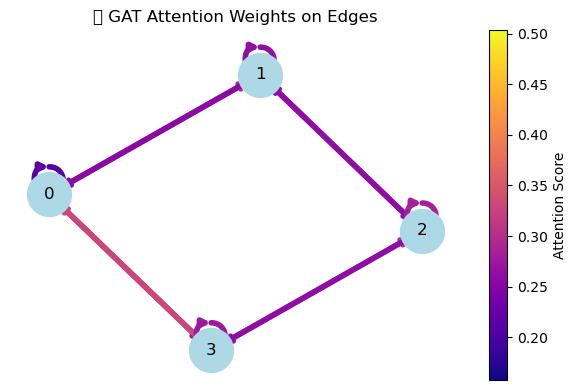

In [11]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Create the graph
G = nx.DiGraph()
edges = edge_index.t().tolist()
G.add_edges_from(edges)

# Node positions
pos = nx.spring_layout(G, seed=48)

# Attention weights
edge_alpha = alpha.squeeze().detach().numpy()
edge_colors = np.clip(edge_alpha, 0, 1)

# Create figure and axes explicitly
fig, ax = plt.subplots(figsize=(6, 4))

# Draw nodes and labels
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000, ax=ax)
nx.draw_networkx_labels(G, pos, ax=ax)

# Draw edges with attention scores as color
edges_drawn = nx.draw_networkx_edges(
    G,
    pos,
    edge_color=edge_colors,
    edge_cmap=plt.cm.plasma,
    edge_vmin=0.0,
    edge_vmax=1.0,
    width=4,
    arrows=True,
    ax=ax
)

# Create colorbar linked to edge colors
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma,
                           norm=plt.Normalize(vmin=edge_colors.min(), vmax=edge_colors.max()))
sm.set_array([])  # Required for colorbar to register correctly
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Attention Score")

# Final plot settings
ax.set_title("🎯 GAT Attention Weights on Edges")
ax.axis("off")
plt.tight_layout()
plt.show()


#### 🎞️ Step 5: (Optional) Animate Node Feature Transformation

In [12]:
from matplotlib.animation import FuncAnimation
import numpy as np

fig, ax = plt.subplots(figsize=(6, 4))
G = nx.from_edgelist(edges, create_using=nx.DiGraph())
nodes = None

def draw_graph(features, title):
    ax.clear()
    vals = features[:, 0]  # 1st dimension of feature
    nx.draw(G, pos, node_color=vals, cmap="plasma", with_labels=True, node_size=1000,
            edge_color='gray', ax=ax)
    ax.set_title(title)
    ax.axis("off")

frames = [x.detach().numpy(), out.detach().numpy()]
titles = ["Before GAT", "After GAT"]

def update(i):
    draw_graph(frames[i], titles[i])

ani = FuncAnimation(fig, update, frames=len(frames), interval=1500, repeat=False)
plt.close()
ani.save("gat_node_transformation.gif", fps=1)

MovieWriter ffmpeg unavailable; using Pillow instead.


## 4) 🧠 HetGNN: Heterogeneous Graph Neural Network

**Paper**: [HetGNN: Heterogeneous Graph Neural Network](https://arxiv.org/abs/1903.07293)  
**Authors**: Yizhou Sun et al., 2019

---

### 🔍 What is a Heterogeneous Graph?

- A **heterogeneous graph** (or **HIN – Heterogeneous Information Network**) contains **multiple types of nodes and/or edges**.
- Example: In a bibliographic graph:
  - **Node types**: Author, Paper, Venue
  - **Edge types**: Writes, Publishes, Cites

---

### 🚀 Motivation for HetGNN

Traditional GNNs like GCN, GAT, or GraphSAGE are designed for **homogeneous** graphs. They:
- Don't differentiate node/edge types.
- Fail to model rich, multi-type semantics in HINs.

**HetGNN** addresses this by:
- Handling **text-rich heterogeneous graphs**
- Using **type-specific encoding** and **hierarchical attention** for aggregation.

---

### 🧱 HetGNN Architecture

HetGNN consists of **three main stages**:

#### 1. **Node Content Encoder**
Each node may have:
- Text content → encoded via a **BiLSTM**
- Other features (numerical, categorical) → encoded accordingly

#### 2. **Homogeneous Neighbor Aggregation**
- For each **node type**, sample **homogeneous neighbors**.
- Encode and aggregate these neighbors **per type** using **LSTM**.

#### 3. **Heterogeneous Type Attention**
- Combine the type-wise embeddings with a **type-level attention mechanism**.
- Learns which **neighbor types** contribute most to the target node representation.

---

### 🧠 Key Ideas Recap

| Component | Description |
|----------|-------------|
| **Type-Aware Sampling** | Neighbors grouped by type |
| **BiLSTM** | For modeling node textual content |
| **LSTM Aggregation** | Models sequential neighbor influence |
| **Attention** | Learns importance of each node type |

---

### 📦 Input & Output

- **Input**: A graph with heterogeneous nodes, textual attributes, and typed edges.
- **Output**: Final node embeddings that capture **multi-typed structural and textual semantics**.

---

### 📈 Benefits

✅ Handles **text-rich, multi-typed** data  
✅ Learns **type-aware semantics**  
✅ Outperforms traditional GNNs on **HIN tasks** (e.g., classification, link prediction)

---

### 📊 Use Cases

- Academic networks (e.g., DBLP)
- Knowledge graphs
- Recommendation systems (users/items/tags/ratings)

---

### 🔧 Code Support

HetGNN is not part of **PyTorch Geometric** by default, but there are open-source implementations and papers you can adapt:
- [`https://github.com/chuxuzhang/HetGNN`](https://github.com/chuxuzhang/HetGNN)

---

#### 🔧 Minimal PyTorch Example of HetGNN

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Config
embedding_dim = 16
hidden_dim = 32
num_types = 3  # e.g., author, paper, venue

# === 1. Node Content Encoder (BiLSTM for text-like input) ===
class ContentEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim // 2, bidirectional=True, batch_first=True)

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, seq_len, input_dim)
        """
        output, _ = self.bilstm(x)
        return torch.mean(output, dim=1)  # Mean pooling over sequence

# === 2. Type-Specific Neighbor Aggregator (LSTM for each type) ===
class TypeAggregator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)

    def forward(self, neighbor_feats):
        """
        neighbor_feats: shape (batch_size, num_neighbors, input_dim)
        """
        out, _ = self.lstm(neighbor_feats)
        return torch.mean(out, dim=1)  # Average over neighbor sequence

# === 3. Heterogeneous Attention Fusion ===
class HetAttention(nn.Module):
    def __init__(self, hidden_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(hidden_dim, out_dim)
        self.attn_vec = nn.Parameter(torch.randn(out_dim))

    def forward(self, type_vectors):
        """
        type_vectors: list of Tensors (num_types x hidden_dim)
        """
        stacked = torch.stack(type_vectors, dim=1)  # shape: (batch, num_types, hidden_dim)
        h = torch.tanh(self.linear(stacked))        # (batch, num_types, out_dim)
        attn_scores = torch.matmul(h, self.attn_vec)  # (batch, num_types)
        attn_weights = F.softmax(attn_scores, dim=1).unsqueeze(-1)  # (batch, num_types, 1)

        # Weighted sum of type vectors
        return torch.sum(stacked * attn_weights, dim=1)  # (batch, hidden_dim)

# === 4. Complete HetGNN Model ===
class HetGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, out_dim, num_types):
        super().__init__()
        self.content_encoder = ContentEncoder(input_dim, hidden_dim)
        self.type_aggregators = nn.ModuleList([TypeAggregator(hidden_dim, hidden_dim) for _ in range(num_types)])
        self.attn = HetAttention(hidden_dim, out_dim)

    def forward(self, x, neighbors_by_type):
        """
        x: (batch_size, seq_len, input_dim)  - content of target nodes
        neighbors_by_type: list of tensors per type
            Each tensor is (batch_size, num_neighbors, seq_len, input_dim)
        """
        batch_size = x.size(0)

        print("===Encoding node content===")
        h_self = self.content_encoder(x)  # (batch, hidden_dim)
        print(h_self)

        h_types = []
        for i, neighbors in enumerate(neighbors_by_type):
            batch_neighbors = neighbors.view(-1, neighbors.size(2), neighbors.size(3))  # flatten
            encoded = self.content_encoder(batch_neighbors)  # (batch * num_neighbors, hidden_dim)
            encoded = encoded.view(batch_size, -1, encoded.size(-1))  # unflatten
            print(f"\n===Encoding type {i} neighbors===")
            print(encoded)
            h_type = self.type_aggregators[i](encoded)  # (batch, hidden_dim)
            h_types.append(h_type)

        # Include self-representation
        h_types.append(h_self)

        print("\n===Attention over types===")
        output = self.attn(h_types)  # (batch, out_dim)
        print(output)
        return output


#### 🧪 Example Usage

In [14]:
batch_size = 2
seq_len = 5
input_dim = 10
num_neighbors = 3

# Random node features and neighbor features
node_content = torch.randn(batch_size, seq_len, input_dim)

neighbors_by_type = [
    torch.randn(batch_size, num_neighbors, seq_len, input_dim),  # Type 0
    torch.randn(batch_size, num_neighbors, seq_len, input_dim),  # Type 1
]

# Model
model = HetGNN(input_dim, hidden_dim, out_dim=64, num_types=len(neighbors_by_type))
output = model(node_content, neighbors_by_type)


===Encoding node content===
tensor([[ 0.2565, -0.1155, -0.0339,  0.0319,  0.0178, -0.1048,  0.0997,  0.1152,
          0.1559, -0.0537,  0.1489,  0.0958, -0.1465,  0.0294, -0.0462,  0.0356,
          0.1300,  0.0119,  0.0868, -0.0156, -0.0675, -0.1923,  0.0010, -0.0107,
          0.1642,  0.1822,  0.0879,  0.1167, -0.0539, -0.0148, -0.1665, -0.0881],
        [ 0.0411, -0.1800,  0.1818,  0.0733, -0.0111, -0.0449,  0.1551, -0.1640,
          0.0812, -0.0168,  0.0248,  0.1296, -0.0483, -0.0824,  0.0261,  0.0307,
          0.0378,  0.0977,  0.0172, -0.0658, -0.1132, -0.0449, -0.0734, -0.0985,
          0.0916,  0.1310,  0.0562, -0.0828, -0.0702, -0.1399, -0.0718,  0.0055]],
       grad_fn=<MeanBackward1>)

===Encoding type 0 neighbors===
tensor([[[ 4.2205e-02, -7.2210e-02,  2.7906e-02,  3.8096e-02, -4.5649e-02,
          -1.3874e-01,  1.2637e-01, -5.2781e-02,  4.9774e-02,  1.5737e-01,
           5.3328e-02, -3.3052e-02, -1.7174e-02, -5.6006e-02, -1.2264e-01,
          -9.8630e-02,  6.5474e